# Get results
This notebook describes the steps necessary to analyze the experimental results and get the plots and tables in the paper. Every cell can be run independently, as the computed data is stored in a temporary directory.

_As some cells require hours to run, the pre-computed results are in a dedicated folder: `src.utils.TMP_DIR`. These cells are commented out._

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import defaultdict
from functools import reduce
from tqdm import tqdm

import src.utils as u
import src.rank_utils as ru
import src.rank_metrics as rm

## Sensitivity analysis
The relative performance of encoders can depend on an ML model, a quality metric, or a tuning strategy.
The choice of an aggregation strategy impacts the consensus ranking.
To quantify the influence of these choices, we calculate the similarity between rankings using the Jaccard index $J$ for the sets of best encoders as well as the Spearman correlation coefficient $\rho$.
For both measures, values close to 1 indicate high agreement between rankings and low sensitivity.
Conversely, values near 0 (or, for $\rho$, negative) suggest low consistency and high sensitivity.

### Sensitivity to experimental factors
We evaluate the sensitivity of encoder rankings on individual datasets with respect to an experimental factor (ML model, quality metric, or tuning strategy) by varying the factor of interest and keeping the other factors fixed, then calculating the similarity between pairs of rankings.
After that, we average the result across all combinations of the other factors.
Our findings highlight the high sensitivity of results of studies comparing encoders to experimental factors, for both the full rankings and the best encoders.
They also explain why results from other studies are not comparable, as choosing different values for any factor will lead to different results.

We now proceed to calculate sensitivity and plot it:

In [2]:
df, rf = u.load_df_rf()

# sensitivity to ML model (model), tuning strategy (tuning), and quality metric (scoring) respectively. The other factors are fixed.
jaccard_model, rho_model = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                             shared_levels=[0, 2, 3])
jaccard_tuning, rho_tuning = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                               shared_levels=[0, 1, 3])
jaccard_scoring, rho_scoring = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                                 shared_levels=[0, 1, 2])

jaccard = reduce(lambda x, y: x.fillna(y), [jaccard_model, jaccard_tuning, jaccard_scoring])
rho = reduce(lambda x, y: x.fillna(y), [rho_model, rho_tuning, rho_scoring])

jaccard.to_csv(u.RANKINGS_DIR / "pw_jaccard.csv")
rho.to_csv(u.RANKINGS_DIR / "pw_rho.csv")

And now we can plot it

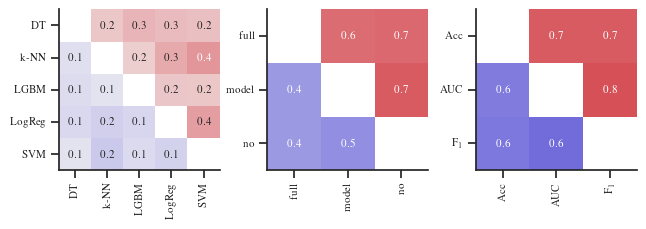

In [3]:
sims = u.load_similarity_dataframes()
rho = sims["pw_rho.csv"]
jaccard = sims["pw_jaccard.csv"]

factors = ["model", "tuning", "scoring"]
similarities = ["rho", "jaccard"]

sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig, axes = plt.subplots(1, len(factors))

for ax, factor in zip(axes, factors):
    df_sim = u.join_wide2long({"jaccard": jaccard, "rho": rho}, comparison_level=factor)
    title = factor
    # if factor == "model":
    #     figsize = (1.8, 1.8)
    # elif factor == "tuning":
    #     figsize = (1.2, 1.2)
    # elif factor == "scoring":
    #     figsize = (1.1, 1.1)
    # else:
    #     raise AssertionError(f"{factor} is an invalid factor.")

    u.heatmap_longformat_multisim(df_sim, similarities, factor, fontsize=8, annot_fontsize=8,
                                  # figsize=figsize,
                                  save_plot=False, show_plot=False, title=title, ax=ax)

plt.show()

### Sensitivity to aggregation strategy

To evaluate the impact of the aggregation strategy on the consensus ranking, we apply the same procedure as above to consensus rankings instead of rankings on individual datasets.
For example, Spearman's $\rho$ between consensus rankings obtained with Q-M and Q-Md averaged across all ML models, tuning strategies, and quality metrics is 0.8.

While some aggregation strategies show strong similarities, different strategies yield very different consensus rankings in general.
This is particularly evident for Jaccard index $J$, indicating the high sensitivity of the best encoders to the rank aggregation strategy.

We begin by computing the consensus rankings with different aggregation strategies.

In [4]:
%%time
consensuses = list()

# --- Aggregation for all aggregation strategies except Nemenyi
consensuses.append(ru.Aggregator(df, rf).aggregate(verbose=True, ignore_strategies=["nemenyi rank"]).aggrf)

# --- Aggregation with Nemenyi with different significance levels
for alpha in [0.01, 0.05, 0.1]:
    consensuses.append(ru.Aggregator(df, rf).aggregate(verbose=True, strategies=["nemenyi rank"], alpha=alpha).aggrf)

aggrf = pd.concat(consensuses, axis=1)
aggrf.to_csv(u.RANKINGS_DIR / "consensuses.csv")

  0%|          | 0/36 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-03


C:\Users\federicom\Documents\GitHub\EncoderBenchmarking\src\rank_utils.py:283: RuntimeWarning: invalid value encountered in true_divide
  c = np.nansum([ms[i] / (w[i] * (w[i]-1)) for i in range(nv)], axis=0)
C:\Users\federicom\Documents\GitHub\EncoderBenchmarking\src\rank_utils.py:283: RuntimeWarning: invalid value encountered in true_divide
  c = np.nansum([ms[i] / (w[i] * (w[i]-1)) for i in range(nv)], axis=0)
C:\Users\federicom\Documents\GitHub\EncoderBenchmarking\src\rank_utils.py:283: RuntimeWarning: invalid value encountered in true_divide
  c = np.nansum([ms[i] / (w[i] * (w[i]-1)) for i in range(nv)], axis=0)


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Wall time: 41min 22s


We then compute the similarity between different consensuses

In [5]:
aggrf = u.load_aggrf().rename(columns=u.AGGREGATION_NAMES, level="aggregation")
agg_jaccard, agg_rho = u.pairwise_similarity_wide_format(aggrf,
                                                         simfuncs=[rm.jaccard_best,
                                                                   rm.spearman_rho],
                                                         shared_levels=slice(-1))

agg_jaccard.to_csv(u.RANKINGS_DIR / "pw_AGG_jaccard.csv")
agg_rho.to_csv(u.RANKINGS_DIR / "pw_AGG_rho.csv")

... and finally plot it.

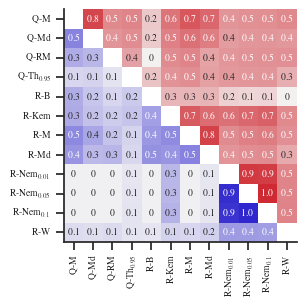

In [6]:
aggsims = u.load_agg_similarities()
agg_jaccard = aggsims["pw_AGG_jaccard.csv"]
agg_rho = aggsims["pw_AGG_rho.csv"]

df_sim = u.join_wide2long({"rho": agg_rho, "jaccard": agg_jaccard}, comparison_level="aggregation")

sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig, ax = plt.subplots(1, 1, figsize=(3, 3.3))
u.heatmap_longformat_multisim(df_sim, ["rho", "jaccard"], "aggregation", fontsize=7, annot_fontsize=7,
                              save_plot=False, show_plot=True, ax=ax, summary_statistic="mean", title=None)

## Replicability

Replicability is the property of a benchmark of obtaining consistent results from different data.
We quantify replicability by comparing consensus rankings aggregated on two disjoint samples of datasets of equal size.
Each data point represents 100 iterations of randomly selecting two disjoint sets of datasets and applying multiple aggregation strategies.
We exclude R-Kem due to its high computational complexity.
Even with 25 datasets, replicability is moderate.
This suggests that consensus rankings vary significantly depending on the data.
Results from logistic regression tend to exhibit the highest replicability among ML models, while decision trees show the lowest.

In [ ]:
%%time
df, rf = u.load_df_rf()
for tuning in ["no", "model", "full"]:
    ru.replicability_analysis(df, rf, tuning, sample_sizes=[5, 10, 15, 20, 25], repetitions=100, append_to_existing=False, save=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

And finally plot everything!

'sample_sim_model.csv' not found in C:\Data\EncoderBenchmarking_results\Rankings.


KeyError: 'aggregation'

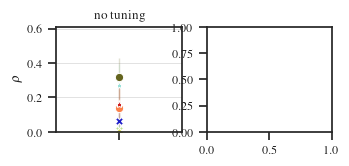

In [9]:
sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig = plt.figure(figsize=(5.5, 3))
gs = fig.add_gridspec(2, 3)

hue = "aggregation"

for isim, sim in enumerate(["rho", "agrbest"]):
    for itun, tuning in enumerate(["no", "model", "full"]):
        sample_df_sim = u.load_sample_similarity_dataframe(tuning=tuning)



        xb = (sim == "agrbest")
        yl = (tuning == "no")

        with sns.axes_style("ticks", {"xtick.bottom": True, "ytick.left": True}):
            ax = fig.add_subplot(gs[isim, itun])

            u.lineplot_longformat_sample_sim(sample_df_sim, similarity=sim, save_plot=False, show_plot=False,
                                             hue=hue,
                                             estimator="mean",
                                             ax=ax,
                                             )
        if not xb:
            ax.set_xlabel(None)
            ax.set_xticklabels([])
        if not yl:
            ax.set_ylabel(None)
            ax.set_yticklabels([])

        ax.grid(axis="y", zorder=-1, linewidth=0.4)

        if tuning == "no":
            handles, labels = ax.get_legend_handles_labels()

        ax.legend().remove()

        if sim == "rho":
            ax.set_title(f"{tuning} tuning")

    plt.tight_layout(w_pad=3, h_pad=1)

    ## hue = model
    # plt.subplots_adjust(top=0.86)
    # plt.figlegend(
    #     handles=handles,
    #     labels=labels,
    #     bbox_to_anchor=(0, 0.86+0.02, 1, 0.2),
    #     loc="lower left",
    #     mode="expand",
    #     borderaxespad=1,
    #     ncol=5,
    #     frameon=False
    # )

    ## hue = aggregation
    plt.subplots_adjust(top=0.8)
    plt.figlegend(
        handles=handles,
        labels=labels,
        bbox_to_anchor=(0, 0.8+0.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=1,
        ncol=5,
        frameon=False
    )

    # hue = scoring
    # plt.subplots_adjust(top=0.86)
    # plt.figlegend(
    #     handles=handles,
    #     labels=labels,
    #     bbox_to_anchor=(0, 0.86+0.02, 1, 0.2),
    #     loc="lower center",
    #     # mode="expand",
    #     borderaxespad=1,
    #     ncol=3,
    #     frameon=False
    # )

sns.despine(trim=True)

## Comparing encoders
We now examine the ranks of encoders limited to decision trees, logistic regression, and all ML models.

The left subplot shows the rank of encoders from the experiments with decision trees across all datasets, quality metrics, and tuning strategies.
One-Hot is the best-performing encoder; however, Nemenyi tests at a significance level of 0.05 fail to reject that the average rank of One-Hot is the same as that of the other encoders.

The central subplot features the encoder ranks for logistic regression, where four encoders, namely One-Hot, Sum, Binary, and Weight of Evidence, consistently achieve higher ranks compared to the others.
Nemenyi tests confirm that this difference in ranks is significant.
These results indicate low replicability of the results for decision trees and higher replicability for logistic regression.

The right plot presents the ranks of encoders across all datasets, ML models, quality metrics, and tuning strategies.
Similarly to logistic regression, One-Hot, Sum, Binary, and Weight of Evidence consistently achieve significantly higher average ranks compared to the other encoders, again confirmed by Nemenyi tests.
We recommend these four encoders as the preferred choices in practical applications.
This conclusion contradicts other studies reporting a suboptimal performance of One-Hot~\cite{cerda_similarity_2018, pargent_regularized_2022}.

Our findings also reveal that Drop performs significantly worse than all other encoders, i.e., encoding categorical attributes generally yields better results than dropping them.

In [ ]:
rf = u.load_rf()

rf_melt = rf.melt(ignore_index=False).reset_index()
rf_melt.columns = ["encoder", "dataset", "model", "tuning", "scoring", "rank"]
rf_melt.encoder = rf_melt.encoder.map(u.ENCODER_LATEX)

sns.set(font_scale=0.8)
sns.set_style("ticks", {"ytick.left": False})
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')


fig, ax = plt.subplots(1, 1, figsize=(1.8, 4.4))
ax = u.sorted_boxplot_horizontal(data=rf_melt, y="encoder", x="rank", order_by="mean",
                                 # palette=sns.light_palette("grey", n_colors=len(rf.index)),
                                 color="lightgrey",
                                 showfliers=False,
                                 linewidth=1, showcaps=False,
                                 showmeans=True,
                                 meanprops={"marker": "o",
                                            "markeredgecolor": "red",
                                            "markersize": 2},
                                 medianprops={"linestyle": "-"
                                 },
                                 ax=ax)
ax.set(xlabel=None, ylabel=None)
ax.set_xlim(0, 32)
ax.set_xticks([0, 10, 20, 30])
ax.grid(axis="x", zorder=-1, linewidth=0.4)
# ax.set_title("(c) All models")

sns.despine(left=True, trim=True)
plt.tight_layout(w_pad=0.5)

In [ ]:
rf = u.load_rf()

model = "KNC"
rf = rf.loc(axis=1)[:, model, :, :]

rf_melt = rf.melt(ignore_index=False).reset_index()
rf_melt.columns = ["encoder", "dataset", "model", "tuning", "scoring", "rank"]
rf_melt.encoder = rf_melt.encoder.map(u.ENCODER_LATEX)

sns.set(font_scale=0.8)
sns.set_style("ticks", {"ytick.left": False})
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')


fig, ax = plt.subplots(1, 1, figsize=(1.8, 4.4))
ax = u.sorted_boxplot_horizontal(data=rf_melt, y="encoder", x="rank", order_by="mean",
                                 # palette=sns.light_palette("grey", n_colors=len(rf.index)),
                                 color="lightgrey",
                                 showfliers=False,
                                 linewidth=1, showcaps=False,
                                 showmeans=True,
                                 meanprops={"marker": "o",
                                            "markeredgecolor": "red",
                                            "markersize": 2},
                                 medianprops={"linestyle": "-"
                                 },
                                 ax=ax)
ax.set(xlabel=None, ylabel=None)
ax.set_xlim(0, 32)
ax.set_xticks([0, 10, 20, 30])
ax.grid(axis="x", zorder=-1, linewidth=0.4)

sns.despine(left=True, trim=True)
plt.tight_layout(w_pad=0.5)